# Business Case Discover


## Carga y Exploración Inicial
Cargar el dataset, visualizar las primeras filas y explorar la distribución de los datos con histogramas y diagramas de caja.
https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

In [ ]:
# Importar librerías necesarias
import pandas as pd

# Cargar el dataset
data = '/data/Housing.csv'
df = pd.read_csv(data)

# Visualizar las primeras filas del dataset
print(df.head())

# Contar datos
print(df.count())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
price               545
area                545
bedrooms            545
bathrooms           545
sto

Comprobar valores nulos en cada columna

In [162]:
# Ver cuántos valores faltantes hay en cada columna
print(df.isnull().sum())

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


### Manejo de valores faltantes

In [163]:
from sklearn.impute import SimpleImputer

# Filtrar solo las columnas numéricas
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Imputar valores faltantes en las columnas numéricas con la mediana
imputer_num = SimpleImputer(strategy='median')
df[numeric_df.columns] = imputer_num.fit_transform(numeric_df)

# Imputar valores faltantes en las columnas categóricas con la moda
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                       'airconditioning', 'prefarea', 'furnishingstatus']

imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = imputer_cat.fit_transform(df[categorical_columns])

### Codificación de variables categóricas

In [164]:
from sklearn.preprocessing import LabelEncoder

# Convertir SOLO las variables binarias a (0/1)
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
label_encoder = LabelEncoder()

for col in binary_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Aplicamos pd.get_dummies() para 'furnishingstatus' (One-Hot Encoding)
df = pd.get_dummies(df, columns=['furnishingstatus']) # drop_first=True reduce la dimensionalidad y evita colinealidad en modelos lineales.

# Convertir las nuevas columnas generadas por pd.get_dummies() (que son booleanas) a 0/1
# Esto se hace dinámicamente, ya que los nombres pueden variar según los valores únicos en 'furnishingstatus'
furnishing_columns = [col for col in df.columns if 'furnishingstatus' in col]

# Convertimos las columnas que contienen 'furnishingstatus' de True/False a 0/1
df[furnishing_columns] = df[furnishing_columns].astype(int)

# Verificar el resultado final
print(df.head(10))

          price      area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0 13,300,000.00  7,420.00      4.00       2.00     3.00         1          0   
1 12,250,000.00  8,960.00      4.00       4.00     4.00         1          0   
2 12,250,000.00  9,960.00      3.00       2.00     2.00         1          0   
3 12,215,000.00  7,500.00      4.00       2.00     2.00         1          0   
4 11,410,000.00  7,420.00      4.00       1.00     2.00         1          1   
5 10,850,000.00  7,500.00      3.00       3.00     1.00         1          0   
6 10,150,000.00  8,580.00      4.00       3.00     4.00         1          0   
7 10,150,000.00 16,200.00      5.00       3.00     2.00         1          0   
8  9,870,000.00  8,100.00      4.00       1.00     2.00         1          1   
9  9,800,000.00  5,750.00      3.00       2.00     4.00         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1     2

### Eliminación de outliers

Podemos eliminar outliers de 2 maneras:
- `Eliminación de outliers usando IQR (Interquartile Range)`: Esta técnica se basa en el rango intercuartílico (IQR), que es la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1) de la distribución de datos. Los valores que están fuera de este rango se consideran outliers.
- `Eliminación de outliers usando desviación estándar`: Este método se basa en la suposición de que los datos siguen una distribución aproximadamente normal. Aquí se utiliza la media y la desviación estándar para determinar los límites fuera de los cuales los valores se consideran outliers.

In [165]:
import pandas as pd
import numpy as np

# Función para eliminar outliers usando IQR con un umbral más alto (3 * IQR)
def remove_outliers_iqr(df, factor=3):
    outliers_count = 0  # Contador de outliers eliminados

    # Para cada columna numérica, calcular el IQR y eliminar outliers
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Definir los límites inferior y superior para los outliers
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Filtrar los outliers fuera de los límites
        outliers_in_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count += len(outliers_in_col)

        # Eliminar outliers de esa columna
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df, outliers_count

# Función para eliminar outliers usando desviación estándar
def remove_outliers_std(df, threshold=3):
    outliers_count = 0  # Contador de outliers eliminados

    # Para cada columna numérica, calcular la desviación estándar y eliminar outliers
    for col in df.select_dtypes(include=[np.number]).columns:
        mean = df[col].mean()
        std = df[col].std()

        # Definir los límites superior e inferior
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std

        # Filtrar los outliers fuera de los límites
        outliers_in_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count += len(outliers_in_col)

        # Eliminar outliers de esa columna
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df, outliers_count

# Selecciona el método de eliminación de outliers que prefieras (IQR o desviación estándar)
#df, outliers_removed_iqr = remove_outliers_iqr(df, factor=3)
df, outliers_removed_std = remove_outliers_std(df, threshold=3)

# Resultados
#print(f"Outliers eliminados (IQR method): {outliers_removed_iqr} filas eliminadas. \n")
print(f"Outliers eliminados (Desviación estándar method): {outliers_removed_std} filas eliminadas.\n")

# Verifica las estadísticas después de la eliminación
print(df.describe())

Outliers eliminados (Desviación estándar method): 46 filas eliminadas.

             price      area  bedrooms  bathrooms  stories  mainroad  \
count       499.00    499.00    499.00     499.00   499.00    499.00   
mean  4,596,768.42  5,017.83      2.92       1.24     1.79      0.86   
std   1,633,853.59  1,930.57      0.70       0.43     0.88      0.35   
min   1,750,000.00  1,650.00      1.00       1.00     1.00      0.00   
25%   3,395,000.00  3,530.00      2.00       1.00     1.00      1.00   
50%   4,270,000.00  4,520.00      3.00       1.00     2.00      1.00   
75%   5,582,500.00  6,310.50      3.00       1.00     2.00      1.00   
max   9,870,000.00 11,460.00      5.00       2.00     4.00      1.00   

       guestroom  basement  hotwaterheating  airconditioning  parking  \
count     499.00    499.00           499.00           499.00   499.00   
mean        0.18      0.35             0.00             0.33     0.65   
std         0.38      0.48             0.00             0.47

## Feature Engineering


### Crear datos sinteticos


In [166]:
import pandas as pd
import numpy as np

def generar_datos_sinteticos(df, n, noise_level=0.05):
    df_synth = df.copy()

    # Seleccionamos columnas numéricas (puedes ajustar esto según necesidad)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Creamos n muestras aleatorias del dataset original
    df_sample = df.sample(n=n, replace=True).reset_index(drop=True)

    # Agregamos ruido
    for col in numeric_cols:
        std = df[col].std()
        noise = np.random.normal(0, noise_level * std, size=n)
        df_sample[col] += noise

    # Aseguramos que los enteros no pierdan su tipo
    for col in df.columns:
        if 'int' in str(df[col].dtype):
            df_sample[col] = df_sample[col].round().astype(int)

    return df_sample

df_sintetico = generar_datos_sinteticos(df, n=3000)
df = pd.concat([df, df_sintetico], ignore_index=True)

Contar cantidad de datos por columnas

In [167]:
df.count()

,0
price,3499
area,3499
bedrooms,3499
bathrooms,3499
stories,3499
mainroad,3499
guestroom,3499
basement,3499
hotwaterheating,3499
airconditioning,3499


### Creación de KPIs

Creamos más columnas a partir de los datos existentes

In [168]:
# Copiar el DataFrame original para no modificar el original
df_featured = df.copy()

# Total de habitaciones (habitaciones + baños)
df_featured['total_rooms'] = df_featured['bedrooms'] + df_featured['bathrooms']

# Área por habitación (área dividida entre el número total de habitaciones)
df_featured['area_per_room'] = df_featured['area'] / df_featured['total_rooms']

# Número de habitaciones por área (habitaciones divididas entre área)
df_featured['bedrooms_per_area'] = df_featured['bedrooms'] / df_featured['area']

# Número de baños por área (baños divididos entre área)
df_featured['bathrooms_per_area'] = df_featured['bathrooms'] / df_featured['area']

# Relación entre el número de baños y el número de habitaciones
df_featured['bedrooms_bathrooms_ratio'] = df_featured['bedrooms'] / df_featured['bathrooms']

# Ratio de baños por habitación
df_featured['bathrooms_per_bedroom'] = df_featured['bathrooms'] / df_featured['bedrooms']

# Habitaciones por planta
df_featured['bedrooms_per_story'] = df_featured['bedrooms'] * df_featured['stories']

# Baños por planta
df_featured['bathroom_stories'] = df_featured['bathrooms'] * df_featured['stories']

# Puntuación de calidad
df_featured['quality_score'] = (
        df_featured['airconditioning'] * 3 +
        df_featured['basement'] * 2 +
        df_featured['guestroom'] * 1.5 +
        df_featured['hotwaterheating'] * 2.5 +
        df_featured['prefarea'] * 3
    )

# Puntuación de conveniencia
df_featured['convenience_score'] = (
    df_featured['mainroad'] * 2 +
    df_featured['parking'] * 1.5 +
    df_featured['prefarea'] * 2
)

# Puntuación de confort
df_featured['comfort_score'] = (
    df_featured['airconditioning'] * 2 +
    df_featured['hotwaterheating'] * 1.5 +
    df_featured['basement'] * 2
)

# Puntuación de amueblado
df_featured['furnishing_score'] = (
    df_featured['furnishingstatus_furnished'] * 3 +
    df_featured['furnishingstatus_semi-furnished'] * 2 +
    df_featured['furnishingstatus_unfurnished'] * 1  # 1 para unfurnished, 2 para semi-furnished
)

# Puntuación de accesibilidad
df_featured['accessibility_score'] = (
    df_featured['mainroad'] * 2 +
    df_featured['area'] / 1000 +
    df_featured['stories'] * 1.5
)

# Puntuación de eficiencia en la distribución de espacios
df_featured['space_efficiency_score'] = (
    df_featured['area'] / (df_featured['bedrooms'] + df_featured['bathrooms']) * 1.5 +
    df_featured['stories'] * 1
)

# Puntuación de lujosidad
df_featured['luxury_score'] = df_featured['quality_score'] * df_featured['convenience_score']
df_featured['quality_per_room'] = df_featured['quality_score'] / df_featured['total_rooms']
df_featured['luxury_per_area'] = df_featured['luxury_score'] / df_featured['area'] * 1000


# Mostrar el DataFrame con los nuevos KPIs
print(df_featured.head())
df = pd.concat([df, df_featured], ignore_index=True)

         price     area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0 9,870,000.00 8,100.00      4.00       1.00     2.00         1          1   
1 9,800,000.00 5,750.00      3.00       2.00     4.00         1          1   
2 9,310,000.00 6,550.00      4.00       2.00     2.00         1          0   
3 9,240,000.00 7,800.00      3.00       2.00     2.00         1          0   
4 9,100,000.00 6,000.00      4.00       1.00     2.00         1          0   

   basement  hotwaterheating  airconditioning  ...  bathroom_stories  \
0         1                0                1  ...              2.00   
1         0                0                1  ...              8.00   
2         0                0                1  ...              4.00   
3         0                0                0  ...              4.00   
4         1                0                0  ...              2.00   

   quality_score  convenience_score  comfort_score  furnishing_score  \
0           9.50          

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6998 entries, 0 to 6997
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            6998 non-null   float64
 1   area                             6998 non-null   float64
 2   bedrooms                         6998 non-null   float64
 3   bathrooms                        6998 non-null   float64
 4   stories                          6998 non-null   float64
 5   mainroad                         6998 non-null   int64  
 6   guestroom                        6998 non-null   int64  
 7   basement                         6998 non-null   int64  
 8   hotwaterheating                  6998 non-null   int64  
 9   airconditioning                  6998 non-null   int64  
 10  parking                          6998 non-null   float64
 11  prefarea                         6998 non-null   int64  
 12  furnishingstatus_fur

### Matriz de correlaciones

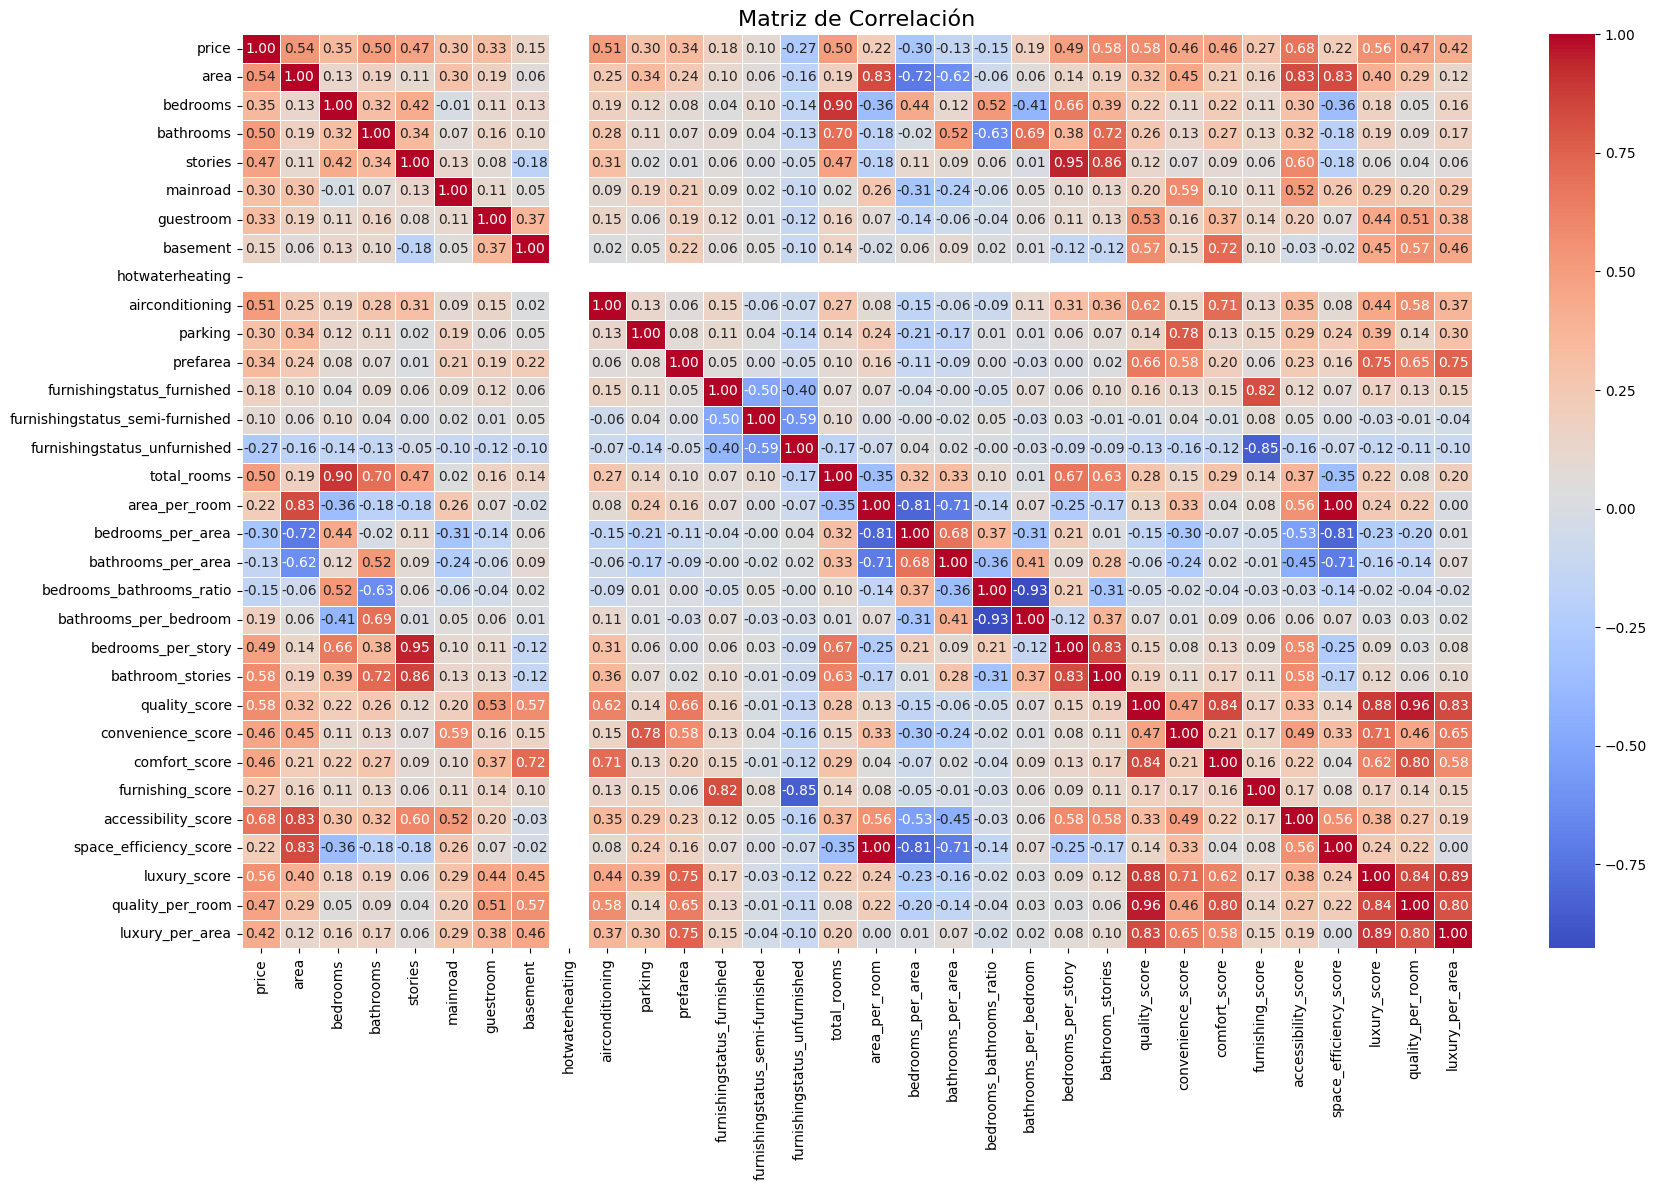


Correlación con la variable objetivo 'price':
price                              1.00
accessibility_score                0.68
bathroom_stories                   0.58
quality_score                      0.58
luxury_score                       0.56
area                               0.54
airconditioning                    0.51
bathrooms                          0.50
total_rooms                        0.50
bedrooms_per_story                 0.49
quality_per_room                   0.47
stories                            0.47
convenience_score                  0.46
comfort_score                      0.46
luxury_per_area                    0.42
bedrooms                           0.35
prefarea                           0.34
guestroom                          0.33
mainroad                           0.30
parking                            0.30
furnishing_score                   0.27
space_efficiency_score             0.22
area_per_room                      0.22
bathrooms_per_bedroom            

In [170]:
# Importar librerías necesarias
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación", fontsize=16)
plt.tight_layout()
plt.show()

# Correlación con la variable objetivo 'price'
correlation_with_price = correlation_matrix['price'].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo 'price':")
print(correlation_with_price)

El valor `NaN` en la correlación de la variable price con `hotwaterheating` indica que no hay datos disponibles o que todos los valores en la columna `hotwaterheating` son constantes (por ejemplo, todos los valores son el mismo, lo que hace que no haya variabilidad para calcular una correlación). Esto puede suceder si esa columna contiene valores nulos, constantes o si hay un problema con los datos en esa columna.

In [171]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import numpy as np
import joblib

# Normalizar la variable objetivo (log transform)
y_log = np.log1p(df_featured['price'])

# Definir las características (X) y la variable objetivo (y)
X = df_featured.drop(columns=['price'])
y = y_log
# y = df.featured['price']

# Dividir el dataset en conjunto de entrenamiento y conjunto de prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar las características (X) con RobustScaler o MinMaxScaler
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Normalizar la variable objetivo (y) con RobustScaler o MinMaxScaler
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")


Dimensiones de X_train: (2799, 31)
Dimensiones de X_test: (700, 31)
Dimensiones de y_train: (2799, 1)
Dimensiones de y_test: (700, 1)


In [172]:
# Guardar el scaler de X
joblib.dump(scaler_X, "scaler_X.joblib")

# Guardar el scaler de y
joblib.dump(scaler_y, "scaler_y.joblib")

['scaler_y.joblib']

In [173]:
print(X_train, X_test)

[[0.5991095  0.74143325 0.0581681  ... 0.22862513 0.24517154 0.18426126]
 [0.14927546 0.49565624 0.06915547 ... 0.00895681 0.         0.02248923]
 [0.98623931 0.5018503  0.0358102  ... 0.32133773 0.30749763 0.17429953]
 ...
 [0.80360606 0.50553416 0.05453666 ... 0.51052949 0.50788441 0.31282544]
 [0.50220987 0.49853814 0.05936899 ... 0.30123421 0.51086135 0.2696119 ]
 [0.20515793 0.2393209  0.06115818 ... 0.00895681 0.         0.02248923]] [[0.47062696 0.47984562 0.09117657 ... 0.18576507 0.3097263  0.17956426]
 [0.50066665 0.48722808 0.9732574  ... 0.10130888 0.24627709 0.10075818]
 [0.37019894 0.50224347 0.05019121 ... 0.18211996 0.61226919 0.20590829]
 ...
 [0.68545242 0.48703885 0.08755973 ... 0.98456887 0.97449225 0.66689532]
 [0.51063201 0.24638602 0.06199481 ... 0.00895681 0.         0.02248923]
 [0.20482514 0.75384978 0.04949724 ... 0.00895681 0.         0.02248923]]


## Creación del modelo

*   Construcción del modelo
*   Definción de parámetros



In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import MeanSquaredError

# Función para construir el modelo
def build_model(input_shape):
    model = Sequential([
        # Capa de entrada - Usar Input en lugar de input_shape en la primera capa
        Input(shape=(input_shape,)),  # Aquí se define la forma de entrada
        Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.2),

        # Capa oculta 1
        Dense(128, activation='relu'),
        Dropout(0.1),

        # Capa oculta 2
        Dense(64, activation='relu'),
        Dropout(0.1),

        # Capa oculta 3
        Dense(32, activation='relu'),
        Dropout(0.1),

        # Capa de salida
        Dense(1, activation='linear')  # Capa final para regresión
    ])

    # Compilación del modelo con optimizador Adam y función de pérdida MSE
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[MeanSquaredError()]
    )

    return model


In [175]:
# Asumiendo que X_train.shape[1] es el número de características (columnas) de tus datos
input_shape = X_train.shape[1]

# Llamamos a la función build_model pasando el número de características como input_shape
model = build_model(input_shape)

# Mostramos el resumen del modelo
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                     │ (None, 32)                  │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,617 (61.00 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 0 (0.00 B)

- early_stopping: Usamos la técnica de early stopping para detener el entrenamiento si no hay mejora en la pérdida de validación, evitando así el sobreajuste.

- monitor='val_loss': Se está monitoreando la pérdida de validación (val_loss). Si esta no mejora después de cierto número de épocas, el entrenamiento se detiene.

- patience=20: Este parámetro indica cuántas épocas esperar antes de detener el entrenamiento si no hay mejora en la pérdida de validación. En este caso, se detendrá después de 20 épocas sin mejora.

- restore_best_weights=True: Cuando se detiene el entrenamiento, se restauran los pesos del modelo de la mejor época (es decir, la época con la menor pérdida de validación).

- Entrenamiento del modelo: El entrenamiento se realiza con el número de épocas y el tamaño del batch que especifiques, utilizando los datos de validación y el callback para evitar el sobreajuste.

In [176]:
from tensorflow.keras.callbacks import EarlyStopping

# Usar early stopping para evitar el sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Definir el callback ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Entrenamiento del modelo
history = model.fit(X_train, y_train,
                    epochs=200,  # Número de épocas, puedes ajustarlo
                    batch_size=32,  # Tamaño del batch, puedes ajustarlo
                    validation_data=(X_test, y_test),  # Usamos los datos de test para la validación
                    callbacks=[early_stopping, checkpoint],  # Usamos el callback de EarlyStopping y el checkpoint
                    verbose=1)  # Muestra el progreso del entrenamiento


Epoch 1/200
69/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0797 - mean_squared_error: 0.0766
Epoch 1: loss improved from inf to 0.04230, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0717 - mean_squared_error: 0.0686 - val_loss: 0.0226 - val_mean_squared_error: 0.0196
Epoch 2/200
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - mean_squared_error: 0.0222
Epoch 2: loss improved from 0.04230 to 0.02438, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0251 - mean_squared_error: 0.0222 - val_loss: 0.0254 - val_mean_squared_error: 0.0226
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230 - mean_squared_error: 0.0202
Epoch 3: loss improved from 0.02438 to 0.02140, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - mean_squared_error: 0.0202 - val_loss: 0.0228 - val_mean_squared_error: 0.0201
Epoch 4/200
81/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - mea

## Evaluación del modelo


### Métricas

- MAE (Error Absoluto Medio):

El MAE mide el promedio de los errores absolutos entre las predicciones y los valores reales. Es una métrica que indica qué tan cerca están las predicciones de los valores reales en promedio. Un MAE más bajo indica un mejor ajuste del modelo.

- MSE (Error Cuadrático Medio):

El MSE es el promedio de los errores cuadráticos, es decir, la diferencia al cuadrado entre las predicciones y los valores reales. Al elevar al cuadrado los errores, el MSE penaliza más los errores grandes, lo que puede ser útil si se desea minimizar la influencia de valores atípicos.

- RMSE (Raíz del Error Cuadrático Medio):

El RMSE es la raíz cuadrada del MSE. Al tomar la raíz cuadrada, se obtiene una métrica que está en la misma unidad que los valores originales, lo que facilita su interpretación. Al igual que el MSE, el RMSE penaliza más los errores grandes.

- R² (Coeficiente de Determinación):

El R² indica la proporción de la varianza en los datos que es explicada por el modelo. Un valor de R² cercano a 1 indica que el modelo explica bien los datos, mientras que un valor cercano a 0 indica que el modelo no explica bien los datos. Es una métrica útil para evaluar la bondad del ajuste del modelo.

In [177]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluación del modelo en el conjunto de prueba
y_pred = model.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calcula el RMSE
rmse = np.sqrt(mse) #np.sqrt(np.mean((y_test - y_pred) ** 2))

# Calcula el valor promedio de los precios reales de test
avg_price = np.mean(y_test)

# Calcula el porcentaje de error
rmse_porcentage = (rmse / avg_price) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse_porcentage:.2f}%")
print(f"R²: {r2:.3f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 0.0430486381665823
MSE: 0.0034762880172045174
RMSE: 10.92%
R²: 0.904


In [178]:
# Convertir y_test y y_pred a arrays de numpy
y_pred_reshaped = np.array(y_pred).reshape(-1, 1)  # Convertir y_pred a 2D si no lo está ya
y_pred_original = scaler_y.inverse_transform(y_pred_reshaped)  # Desnormalizar las predicciones

y_test_reshaped = np.array(y_test).reshape(-1, 1)  # Convertir y_test a 2D si no lo está ya
y_test_original = scaler_y.inverse_transform(y_test_reshaped)  # Desnormalizar los valores reales

# Calcular el MSE, RMSE y R2 en la escala original
mae_real = mean_absolute_error(y_test_original, y_pred_original)
mse_real = mean_squared_error(y_test_original, y_pred_original)
r2_real = r2_score(y_test_original, y_pred_original)
rmse_real = np.sqrt(mse_real)

# Calcular el porcentaje de RMSE
avg_y_real = np.mean(y_test_original)
rmse_percentage_real = (rmse_real / avg_y_real) * 100

# Mostrar los resultados
print(f"Test MAE (desnormalizado): {mae_real}")
print(f"Test MSE (desnormalizado): {mse_real}")
print(f"Test RMSE (desnormalizado): {rmse_real:.2f}%")
print(f"Test R² (desnormalizado): {r2_real:.3f}")

Test MAE (desnormalizado): 0.07863281812023777
Test MSE (desnormalizado): 0.011598576092133552
Test RMSE (desnormalizado): 0.11%
Test R² (desnormalizado): 0.904


### Guardar el modelo

In [179]:
# Guardar el modelo
model.save("prediccion_precio_casas.keras")

In [180]:
# Guardar el modelo
model.save("prediccion_precio_casas.h5")

## Análisis y Resultados

### Gráficos de error

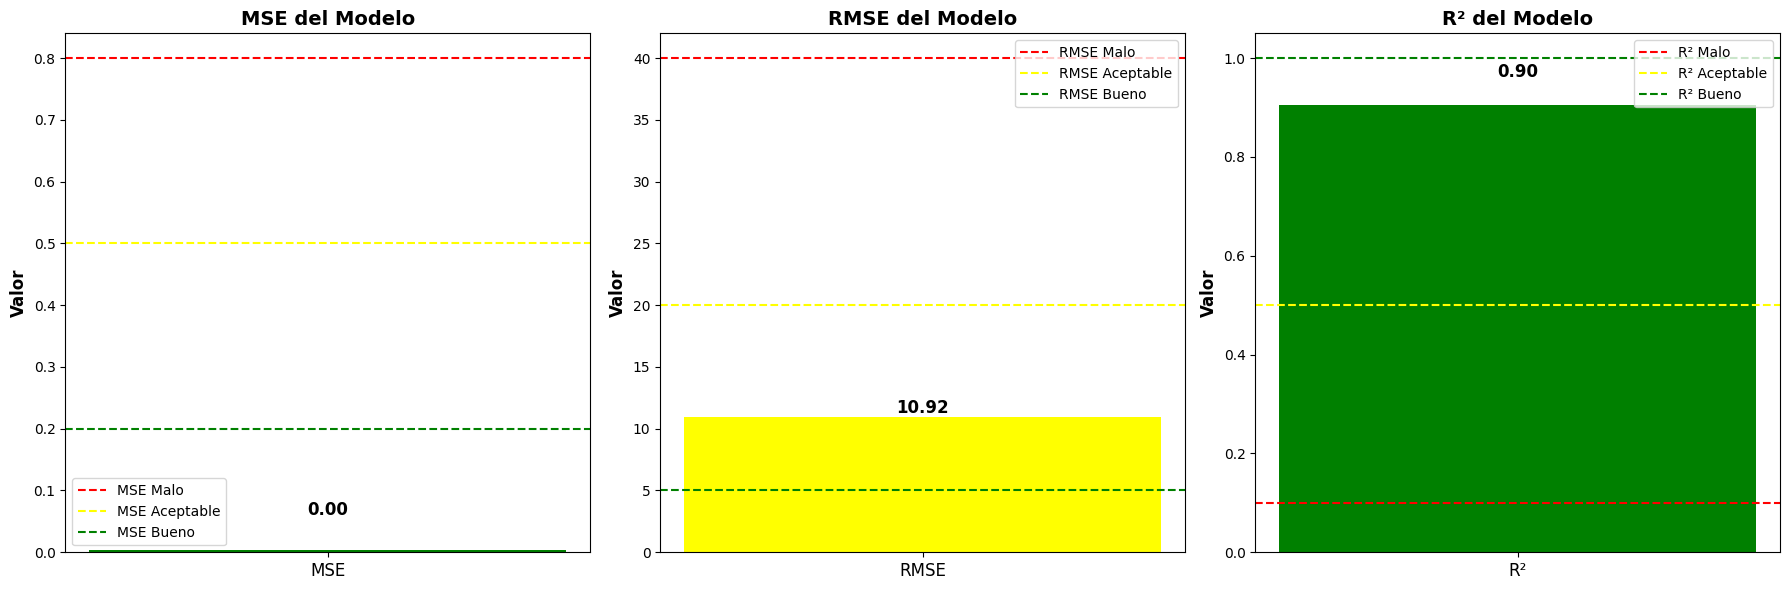

In [181]:
import matplotlib.pyplot as plt

# Definir las métricas
metrics = {'MSE': mse, 'RMSE': rmse_porcentage, 'R²': r2}

# Definir los rangos para cada métrica (Malo, Aceptable, Bueno)
ranges = {
    'MSE': {'min': 0.8, 'acceptable': 0.5, 'max': 0.2},  # Ejemplo: MAE malo > 0.8, aceptable entre 0.5 y 0.2, bueno < 0.2
    'RMSE': {'min': 40, 'acceptable': 20, 'max': 5},  # Ejemplo: RMSE malo > 1.0, aceptable entre 0.6 y 0.2, bueno < 0.2
    'R²': {'min': 0.1, 'acceptable': 0.5, 'max': 1}    # Ejemplo: R² malo < 0.1, aceptable entre 0.5 y 0.9, bueno > 0.9
}

# Crear los gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Para cada métrica, generar un gráfico
for i, (metric, value) in enumerate(metrics.items()):
    ax = axes[i]

    # Determinar el color según el valor de la métrica
    if value <= ranges[metric]['max']:
        color = 'green'  # Bueno
    elif value <= ranges[metric]['acceptable']:
        color = 'yellow'  # Aceptable
    else:
        color = 'red'  # Malo

    # Graficar la barra
    ax.bar(metric, value, color=color)
    ax.text(0, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Añadir las líneas que marcan los límites para cada rango
    ax.axhline(y=ranges[metric]['min'], color='red', linestyle='--', label=f'{metric} Malo')
    ax.axhline(y=ranges[metric]['acceptable'], color='yellow', linestyle='--', label=f'{metric} Aceptable')
    ax.axhline(y=ranges[metric]['max'], color='green', linestyle='--', label=f'{metric} Bueno')

    # Añadir título y etiquetas
    ax.set_title(f"{metric} del Modelo", fontsize=14, fontweight='bold')
    ax.set_ylabel("Valor", fontsize=12, fontweight='bold')
    ax.set_xticks([0])
    ax.set_xticklabels([metric], fontsize=12)

    # Añadir leyenda
    ax.legend(fontsize=10)

# Mejorar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Gráfico de dispersión de valores reales y predicciones

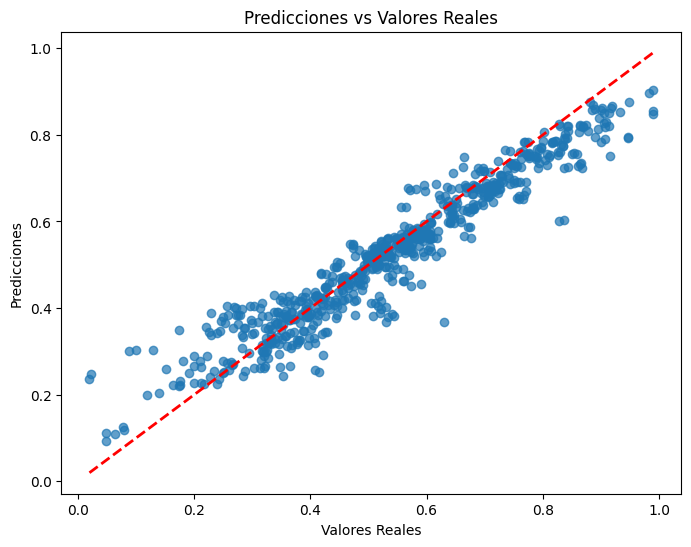

In [182]:
import matplotlib.pyplot as plt

# Predicciones vs Reales
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Línea de identidad
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

## Uso del modelo

### Carga del modelo

In [183]:
# Cargar el scaler
scaler = joblib.load('scaler_X.joblib')  # Asegúrate de que este archivo exista

# Verifica las dimensiones de X_test
print("Dimensiones de X_test:", X_test.shape)

# Asegúrate de que X_test tiene las mismas columnas que los datos originales usados para entrenar el scaler
# Si X_test es un DataFrame, asegúrate de que las columnas sean las correctas
# Si X_test no tiene el mismo número de columnas, esto causará el error

# Invertir la normalización de X_test (debe tener las mismas columnas que los datos originales)
X_original = scaler.inverse_transform(X_test)

# Verificar el resultado
print("Datos invertidos (X_original):", X_original)

Dimensiones de X_test: (700, 31)
Datos invertidos (X_original): [[6.30006415e+03 2.92085611e+00 1.03701794e+00 ... 1.20733102e+01
  7.57982685e-01 1.91637894e+00]
 [6.60399390e+03 2.95131145e+00 2.02624315e+00 ... 6.30623906e+00
  6.02705594e-01 9.54912914e-01]
 [5.28397301e+03 3.01325539e+00 9.91054176e-01 ... 1.18244050e+01
  1.49838565e+00 2.23778678e+00]
 ...
 [8.47358367e+03 2.95053081e+00 1.03296176e+00 ... 6.66194413e+01
  2.38484190e+00 7.86201493e+00]
 [6.70481952e+03 1.95775055e+00 1.00429153e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.61078588e+03 4.05122272e+00 9.90275906e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [184]:
import joblib
import numpy as np
import pandas as pd

# Cargar el scaler de la variable objetivo (y)
scaler_y = joblib.load('scaler_y.joblib')  # Asegúrate de cargar el scaler correcto

# Hacer las predicciones sobre los datos de prueba
y_pred_scaled = model.predict(X_test)

# Asegurarse de que las predicciones estén en el formato adecuado (2D)
y_pred_scaled = y_pred_scaled.reshape(-1, 1)

# Invertir la transformación de las predicciones (volver a la escala original)
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)

# Invertir la transformación de y_test (volver a la escala original)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Asegúrate de que y_test sea 2D

# Calcular el error porcentual
error_percentage = np.abs((y_test_original - y_pred_original) / y_test_original) * 100

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Real Price': y_test_original.flatten(),
    'Predicted Price': y_pred_original.flatten(),
    'Error (%)': error_percentage.flatten()
})

# Mostrar las primeras filas de los resultados
print(results.head())


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
   Real Price  Predicted Price  Error (%)
0       15.54            15.47       0.47
1       15.61            15.55       0.41
2       14.60            14.70       0.72
3       15.26            15.28       0.16
4       15.16            15.12       0.29


In [185]:
# Invertimos la Transformación Logaritmica

# Cargar el scaler
scaler = joblib.load('scaler_y.joblib')  # Asegúrate de que este archivo exista

# Hacer las predicciones sobre los datos de prueba
y_pred_scaled = model.predict(X_test)

# Invertir la transformación de las predicciones (volver a la escala original)
y_pred_log = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Invertir la transformación logarítmica
y_pred_original = np.expm1(y_pred_log)

# Invertir la transformación de y_test (volver a la escala original)
y_test_log = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Invertir la transformación logarítmica
y_test_original = np.expm1(y_test_log)

# Calcular el error porcentual
error_percentage = np.abs((y_test_original - y_pred_original) / y_test_original) * 100

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Real Price': y_test_original,
    'Predicted Price': y_pred_original,
    'Error (%)': error_percentage
})

# Mostrar las primeras filas de los resultados
print(results)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
      Real Price  Predicted Price  Error (%)
0   5,599,529.40     5,208,527.50       6.98
1   6,025,589.48     5,656,122.00       6.13
2   2,184,960.11     2,428,777.50      11.16
3   4,228,733.01     4,330,495.50       2.41
4   3,850,000.00     3,686,701.75       4.24
..           ...              ...        ...
695 3,001,427.83     3,301,997.25      10.01
696 5,595,241.15     5,146,737.00       8.02
697 5,203,984.95     5,163,073.00       0.79
698 3,081,650.13     3,239,298.50       5.12
699 4,261,490.35     4,325,336.50       1.50

[700 rows x 3 columns]


In [186]:
# Configurar el formato de visualización de números flotantes
pd.options.display.float_format = '{:,.2f}'.format

# Mostrar las primeras filas del DataFrame con el formato actualizado
print(results.head())

    Real Price  Predicted Price  Error (%)
0 5,599,529.40     5,208,527.50       6.98
1 6,025,589.48     5,656,122.00       6.13
2 2,184,960.11     2,428,777.50      11.16
3 4,228,733.01     4,330,495.50       2.41
4 3,850,000.00     3,686,701.75       4.24


In [187]:
# Verificar la forma de la entrada que espera el modelo
print(model.input_shape)

(None, 31)


In [188]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Cargar el modelo
model = tf.keras.models.load_model("prediccion_precio_casas.keras")

# Ejemplo con múltiples datos
data_multiple_to_predict = [
    [7420, 4, 2, 3, 1, 0, 0, 0, 1, 2, 1, 1, 0, 0],  # Caso 1
    [8960, 4, 4, 4, 1, 0, 0, 0, 1, 3, 0, 1, 0, 0],  # Caso 2
    [9960, 3, 2, 2, 1, 0, 1, 0, 0, 2, 1, 0, 1, 0],  # Caso 3
    [7500, 4, 2, 2, 1, 0, 1, 0, 1, 3, 1, 1, 0, 0],  # Caso 4
    [7420, 4, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 0, 0],  # Caso 5
    [7500, 3, 3, 1, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0],  # Caso 6
    [8580, 4, 3, 4, 1, 0, 0, 0, 1, 2, 1, 0, 1, 0],  # Caso 7
    [16200, 5, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # Caso 8
    [8100, 4, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 0, 0],  # Caso 9
    [5750, 3, 2, 4, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1],  # Caso 10
    [13200, 3, 1, 2, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0],  # Caso 11
    [6000, 4, 3, 2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0],  # Caso 12
    [6550, 4, 2, 2, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0],  # Caso 13
    [3500, 4, 2, 2, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0],  # Caso 14
    [7800, 3, 2, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]  # Caso 15
]

# Convertir a DataFrame para calcular las características adicionales
columnas_originales = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
                        'basement', 'hotwaterheating', 'airconditioning', 'parking',
                        'prefarea', 'furnishingstatus_furnished', 'furnishingstatus_semi-furnished',
                        'furnishingstatus_unfurnished']

df_pred = pd.DataFrame(data_multiple_to_predict, columns=columnas_originales)

df_pred.head()

# Generar nuevas características (mismo proceso que aplicaste antes)
df_pred['total_rooms'] = df_pred['bedrooms'] + df_pred['bathrooms']
df_pred['area_per_room'] = df_pred['area'] / df_pred['total_rooms']
df_pred['bedrooms_per_area'] = df_pred['bedrooms'] / df_pred['area']
df_pred['bathrooms_per_area'] = df_pred['bathrooms'] / df_pred['area']
df_pred['bedrooms_bathrooms_ratio'] = df_pred['bedrooms'] / df_pred['bathrooms']
df_pred['bathrooms_per_bedroom'] = df_pred['bathrooms'] / df_pred['bedrooms']
df_pred['bedrooms_per_story'] = df_pred['bedrooms'] * df_pred['stories']
df_pred['bathroom_stories'] = df_pred['bathrooms'] * df_pred['stories']

df_pred['quality_score'] = (
        df_pred['airconditioning'] * 3 +
        df_pred['basement'] * 2 +
        df_pred['guestroom'] * 1.5 +
        df_pred['hotwaterheating'] * 2.5 +
        df_pred['prefarea'] * 3
    )

df_pred['convenience_score'] = (
    df_pred['mainroad'] * 2 +
    df_pred['parking'] * 1.5 +
    df_pred['prefarea'] * 2
)

df_pred['comfort_score'] = (
    df_pred['airconditioning'] * 2 +
    df_pred['hotwaterheating'] * 1.5 +
    df_pred['basement'] * 2
)

df_pred['furnishing_score'] = (
    df_pred['furnishingstatus_furnished'] * 3 +
    df_pred['furnishingstatus_semi-furnished'] * 2 +
    df_pred['furnishingstatus_unfurnished'] * 1
)

df_pred['accessibility_score'] = (
    df_pred['mainroad'] * 2 +
    df_pred['area'] / 1000 +
    df_pred['stories'] * 1.5
)

df_pred['space_efficiency_score'] = (
    df_pred['area'] / df_pred['total_rooms'] * 1.5 +
    df_pred['stories'] * 1
)

df_pred['luxury_score'] = df_pred['quality_score'] * df_pred['convenience_score']
df_pred['quality_per_room'] = df_pred['quality_score'] / df_pred['total_rooms']
df_pred['luxury_per_area'] = df_pred['luxury_score'] / df_pred['area'] * 1000

df_pred.head()


,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,...,bathroom_stories,quality_score,convenience_score,comfort_score,furnishing_score,accessibility_score,space_efficiency_score,luxury_score,quality_per_room,luxury_per_area
0,7420,4,2,3,1,0,0,0,1,2,...,6,6.00,7.00,2.00,3,13.92,"1,858.00",42.00,1.00,5.66
1,8960,4,4,4,1,0,0,0,1,3,...,16,3.00,6.50,2.00,3,16.96,"1,684.00",19.50,0.38,2.18
2,9960,3,2,2,1,0,1,0,0,2,...,4,5.00,7.00,2.00,2,14.96,"2,990.00",35.00,1.00,3.51
3,7500,4,2,2,1,0,1,0,1,3,...,4,8.00,8.50,4.00,3,12.50,"1,877.00",68.00,1.33,9.07
4,7420,4,1,2,1,1,1,0,1,2,...,2,6.50,5.00,4.00,3,12.42,"2,228.00",32.50,1.30,4.38


In [189]:
# Hacer la predicción
prediction = model.predict(df_pred)

# Mostrar resultados
for i, price in enumerate(prediction):
    print(f"Predicción para casa {i+1}: ${price[0]:,.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicción para casa 1: $95.02
Predicción para casa 2: $129.99
Predicción para casa 3: $114.63
Predicción para casa 4: $96.35
Predicción para casa 5: $85.88
Predicción para casa 6: $96.05
Predicción para casa 7: $118.24
Predicción para casa 8: $233.29
Predicción para casa 9: $94.15
Predicción para casa 10: $67.28
Predicción para casa 11: $134.70
Predicción para casa 12: $82.87
Predicción para casa 13: $83.87
Predicción para casa 14: $45.12
Predicción para casa 15: $89.71


In [190]:
# Preprocesar los datos de entrada (como se hizo con los datos de entrenamiento)
data_multiple_to_predict_scaled = scaler_X.transform(df_pred)  # Usar el scaler_X entrenado

# Realizar la predicción (en la escala logarítmica)
log_predictions = model.predict(data_multiple_to_predict_scaled)

# Desescalar la predicción de y (invertir MinMaxScaler)
log_predictions = scaler_y.inverse_transform(log_predictions)

# Aplicar la transformación inversa log1p para obtener el precio original
predictions_original_scale = np.expm1(log_predictions)  # Inverso de log1p

# Precios reales (en el mismo orden que las casas predichas)
real_prices = [
    13300000, 12250000, 12250000, 12215000, 11410000, 10850000, 10150000, 10150000,
    9870000, 9800000, 9800000, 9681000, 9310000, 9240000, 9240000, 9100000, 9100000,
    8960000, 8890000, 8855000, 8750000, 8680000, 8645000, 8645000, 8575000, 8540000,
    8463000, 8400000, 8400000, 8400000, 8400000, 8400000, 8295000, 8190000
]

# Mostrar los resultados
for i, price in enumerate(predictions_original_scale):
    predicted_price = price[0]  # Precio predicho
    real_price = real_prices[i]  # Precio real
    print(f"Casa {i+1}:")
    print(f"  Precio real: ${real_price:,.2f}")
    print(f"  Precio predicho: ${predicted_price:,.2f}")
    print(f"  Diferencia: ${abs(real_price - predicted_price):,.2f}")
    print('-' * 40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Casa 1:
  Precio real: $13,300,000.00
  Precio predicho: $7,083,658.00
  Diferencia: $6,216,342.00
----------------------------------------
Casa 2:
  Precio real: $12,250,000.00
  Precio predicho: $11,500,358.00
  Diferencia: $749,642.00
----------------------------------------
Casa 3:
  Precio real: $12,250,000.00
  Precio predicho: $6,814,132.50
  Diferencia: $5,435,867.50
----------------------------------------
Casa 4:
  Precio real: $12,215,000.00
  Precio predicho: $7,116,980.00
  Diferencia: $5,098,020.00
----------------------------------------
Casa 5:
  Precio real: $11,410,000.00
  Precio predicho: $5,980,645.00
  Diferencia: $5,429,355.00
----------------------------------------
Casa 6:
  Precio real: $10,850,000.00
  Precio predicho: $7,310,197.00
  Diferencia: $3,539,803.00
----------------------------------------
Casa 7:
  Precio real: $10,150,000.00
  Precio predicho: $9,525,752.00
  Diferencia: $624,248.00
--------------------------